# Question: What proportion of Wikipedia pages are edited at least once per month?

In [7]:
import requests
import time
import pandas as pd

In [8]:
url = "https://en.wikipedia.org/w/api.php"

In [9]:
params = {
    "action": "query",
    "list": "random",
    "rnnamespace": 0,   # articles only
    "rnlimit": 10,      # sample size n
    "format": "json"
}

headers = {
    'User-Agent': 'StatisticsEducationBot/1.0 (Statistics Class Project; educational use)'
}

In [10]:
session = requests.Session()
response = session.get(url=url, params=params, headers=headers)

print("Status code:", response.status_code)
data = response.json()
data

Status code: 200


{'batchcomplete': '',
 'continue': {'rncontinue': '0.592840586048|0.592843071387|78838781|0',
  'continue': '-||'},
 'query': {'random': [{'id': 67716374, 'ns': 0, 'title': 'Brookesia brunoi'},
   {'id': 14714688, 'ns': 0, 'title': 'Aspach, Upper Austria'},
   {'id': 216888, 'ns': 0, 'title': 'Faculty of Engineering, Lund University'},
   {'id': 7302987, 'ns': 0, 'title': 'Amos Kling House'},
   {'id': 72947287, 'ns': 0, 'title': 'Tomas Giraldo'},
   {'id': 31370173, 'ns': 0, 'title': 'Kilfeacle and District RFC'},
   {'id': 80455647,
    'ns': 0,
    'title': "2025 European Athletics U23 Championships – Women's high jump"},
   {'id': 66279907, 'ns': 0, 'title': 'Abdul Wahab Khan'},
   {'id': 3690483, 'ns': 0, 'title': 'Frozen section procedure'},
   {'id': 19746947,
    'ns': 0,
    'title': 'Georgia State Board of Pardons and Paroles'}]}}

In [12]:
article_title = data['query']['random'][0]['title']
print(f"Article: {article_title}\n")

Article: Brookesia brunoi



In [13]:
content_params = {
    "action": "query",
    "titles": article_title,
    "prop": "extracts",  # This gets the text content
    "explaintext": True,  # Plain text instead of HTML
    "format": "json"
}

response = session.get(url=url, params=content_params, headers=headers)
data = response.json()

pages = data['query']['pages']
page_id = list(pages.keys())[0]
content = pages[page_id].get('extract', 'No content available')

print("Page content:")
print(content)

Page content:
Brookesia brunoi is a species of chameleon. It is found in Madagascar. Brookesia brunoi belongs to the Brookesia decaryi group. Brookesia brunoi, uniquely, does not have enlarged pointed tubercles around the vent.


== References ==
3.  Crottini, A., Miralles, A., Glaw, F., Harris, D. J., Lima, A., & Vences, M. (2012). Description of a new pygmy chameleon (Chamaeleonidae: Brookesia) from central Madagascar. Zootaxa, 3490(1), 63. https://doi.org/10.11646/zootaxa.3490.1.5


In [24]:
import requests
import pandas as pd
from datetime import datetime, timedelta, timezone
import time
from requests.exceptions import RequestException

# -----------------------------
# SETTINGS
# -----------------------------
NUM_SAMPLES = 10
ENDPOINT = "https://en.wikipedia.org/w/api.php"
ONE_MONTH_AGO = datetime.now(timezone.utc) - timedelta(days=30)

HEADERS = {
    "User-Agent": "SpookSpeakerProject/1.0 (student@example.com) Python/requests"
}
RETRIES = 3
SLEEP_BETWEEN_RETRIES = 1.0

# -----------------------------
# HELPER FUNCTION
# -----------------------------
def safe_get_json(params, context):
    for attempt in range(1, RETRIES + 1):
        try:
            resp = requests.get(ENDPOINT, params=params, headers=HEADERS, timeout=10)
        except RequestException as e:
            print(f"[Network error] {context}, try {attempt} → {e}")
            if attempt < RETRIES:
                time.sleep(SLEEP_BETWEEN_RETRIES)
                continue
            raise
        if resp.status_code != 200:
            print(f"[HTTP {resp.status_code}] {context}, try {attempt}. Response:\n{resp.text[:200]}")
            if attempt < RETRIES:
                time.sleep(SLEEP_BETWEEN_RETRIES)
                continue
            resp.raise_for_status()
        try:
            return resp.json()
        except ValueError:
            print(f"[JSON error] {context}, try {attempt}. Text:\n{resp.text[:200]}")
            if attempt < RETRIES:
                time.sleep(SLEEP_BETWEEN_RETRIES)
                continue
            raise
    raise RuntimeError("safe_get_json failed for " + context)

# -----------------------------
# COLLECT DATA
# -----------------------------
data = {
    "title": [],
    "last_edit_timestamp": [],
    "edited_in_last_month": []
}

for i in range(NUM_SAMPLES):
    # Get a random page
    rnd_params = {
        "action": "query",
        "list": "random",
        "rnnamespace": 0,
        "rnlimit": 1,
        "format": "json"
    }
    rnd_json = safe_get_json(rnd_params, f"random page {i+1}")
    title = rnd_json["query"]["random"][0]["title"]

    # Get revision timestamp
    rev_params = {
        "action": "query",
        "prop": "revisions",
        "titles": title,
        "rvprop": "timestamp",
        "rvlimit": 1,
        "format": "json"
    }
    rev_json = safe_get_json(rev_params, f"revision for {title}")
    pages = rev_json["query"]["pages"]
    pageid = next(iter(pages))
    page = pages[pageid]

    timestamp = None
    edited_flag = 0
    if "revisions" in page:
        timestamp = page["revisions"][0]["timestamp"]
        # Convert to datetime aware of UTC
        last_edit = datetime.fromisoformat(timestamp.replace("Z", "+00:00"))
        if last_edit > ONE_MONTH_AGO:
            edited_flag = 1

    data["title"].append(title)
    data["last_edit_timestamp"].append(timestamp)
    data["edited_in_last_month"].append(edited_flag)

    # Be polite to the API
    time.sleep(0.5)

# -----------------------------
# MAKE DATAFRAME
# -----------------------------
df = pd.DataFrame(data)

# Convert timestamp column to datetime type (UTC-aware)
df["last_edit_datetime"] = pd.to_datetime(df["last_edit_timestamp"], utc=True)

# Drop the raw timestamp string if you like
df = df.drop(columns=["last_edit_timestamp"])

# Calculate sample proportion
p_hat = df["edited_in_last_month"].mean()

# -----------------------------
# OUTPUT
# -----------------------------
print(df)
print(f"\nSample proportion (p̂) = {p_hat:.2f}")

# Optionally: save to CSV
# df.to_csv("wiki_edit_sample.csv", index=False)


                                           title  edited_in_last_month  \
0                                    Yasin Malik                     0   
1                           La France au travail                     0   
2                                 Georges Dandoy                     0   
3                             Acraephnes litodes                     0   
4                          Montebello sul Sangro                     0   
5                                Errico Petrella                     0   
6                                     Ruth Price                     0   
7  1988 NCAA Division II men's soccer tournament                     0   
8                    William F. Baker (engineer)                     1   
9                          Gartell Light Railway                     0   

         last_edit_datetime  
0 2025-10-03 14:45:48+00:00  
1 2025-05-27 22:18:33+00:00  
2 2025-10-11 07:15:57+00:00  
3 2024-06-30 20:49:14+00:00  
4 2024-06-25 10:48:45+00:00  
5 202

   sample_proportion
0              0.198
1              0.200
2              0.182
3              0.180
4              0.198


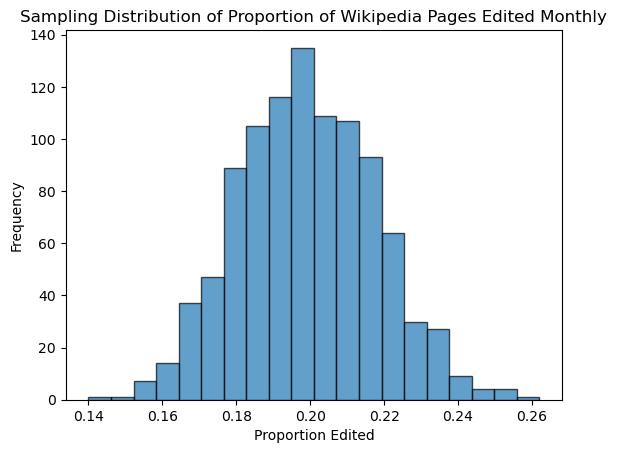

Mean of sample proportions: 0.199
Standard deviation: 0.018
Margin of Error (95% confidence): 0.035


In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# -----------------------------
# PARAMETERS
# -----------------------------
num_pages = 100000  # total pages to simulate
num_samples = 1000  # number of samples
sample_size = 500   # pages per sample

# Simulate whether a page is edited in a month (1 = edited, 0 = not edited)
np.random.seed(42)
pages = np.random.binomial(1, 0.2, num_pages)

# -----------------------------
# COLLECT SAMPLES
# -----------------------------
sample_props = []
for _ in range(num_samples):
    sample = np.random.choice(pages, size=sample_size, replace=False)
    prop_edited = np.mean(sample)
    sample_props.append(prop_edited)

# -----------------------------
# CREATE DATAFRAME
# -----------------------------
df = pd.DataFrame({'sample_proportion': sample_props})
print(df.head())

# -----------------------------
# VISUALIZE SAMPLING DISTRIBUTION
# -----------------------------
plt.hist(df['sample_proportion'], bins=20, edgecolor='k', alpha=0.7)
plt.title("Sampling Distribution of Proportion of Wikipedia Pages Edited Monthly")
plt.xlabel("Proportion Edited")
plt.ylabel("Frequency")
plt.show()

# -----------------------------
# SUMMARY STATISTICS
# -----------------------------
mean_prop = df['sample_proportion'].mean()
std_prop = df['sample_proportion'].std()
print(f"Mean of sample proportions: {mean_prop:.3f}")
print(f"Standard deviation: {std_prop:.3f}")

# -----------------------------
# MARGIN OF ERROR
# -----------------------------
confidence_level = 0.95
z_score = norm.ppf(0.5 + confidence_level/2)  # z ≈ 1.96 for 95%
margin_of_error = z_score * std_prop

print(f"Margin of Error (95% confidence): {margin_of_error:.3f}")


   sample_proportion
0              0.198
1              0.200
2              0.182
3              0.180
4              0.198


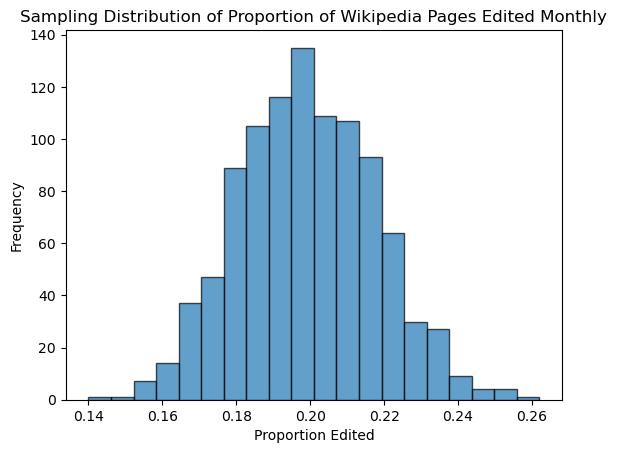

Mean of sample proportions: 0.199
Standard Error: 0.018
Margin of Error (95% confidence): 0.035
95% Confidence Interval: (0.164, 0.235)


In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# -----------------------------
# PARAMETERS
# -----------------------------
num_pages = 100000  # total pages to simulate
num_samples = 1000  # number of samples
sample_size = 500   # pages per sample

# Simulate whether a page is edited in a month (1 = edited, 0 = not edited)
np.random.seed(42)
pages = np.random.binomial(1, 0.2, num_pages)

# -----------------------------
# COLLECT SAMPLES
# -----------------------------
sample_props = []
for _ in range(num_samples):
    sample = np.random.choice(pages, size=sample_size, replace=False)
    prop_edited = np.mean(sample)
    sample_props.append(prop_edited)

# -----------------------------
# CREATE DATAFRAME
# -----------------------------
df = pd.DataFrame({'sample_proportion': sample_props})
print(df.head())

# -----------------------------
# VISUALIZE SAMPLING DISTRIBUTION
# -----------------------------
plt.hist(df['sample_proportion'], bins=20, edgecolor='k', alpha=0.7)
plt.title("Sampling Distribution of Proportion of Wikipedia Pages Edited Monthly")
plt.xlabel("Proportion Edited")
plt.ylabel("Frequency")
plt.show()

# -----------------------------
# SUMMARY STATISTICS
# -----------------------------
mean_prop = df['sample_proportion'].mean()
std_error = df['sample_proportion'].std()  # standard error of sample distribution

# 95% confidence
confidence_level = 0.95
z_score = norm.ppf(0.5 + confidence_level/2)
margin_of_error = z_score * std_error

# Confidence interval
ci_lower = mean_prop - margin_of_error
ci_upper = mean_prop + margin_of_error

print(f"Mean of sample proportions: {mean_prop:.3f}")
print(f"Standard Error: {std_error:.3f}")
print(f"Margin of Error (95% confidence): {margin_of_error:.3f}")
print(f"95% Confidence Interval: ({ci_lower:.3f}, {ci_upper:.3f})")


# Conclusion: Approximately 20% of Wikipedia pages are edited at least once per month, and we are 95% confident that the true proportion is between 16% and 24%.